CS524: Introduction to Optimization Project
======================================

### By Gauri Shrikant Patki


In [1296]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import NormalDist
import sys

from gamspy import (
    Container,Set,Alias,Parameter,Variable,Equation,Model,Problem,Sense,Options,
    Domain,Number,Sum,Product,Smax,Smin,Ord,Card,SpecialValues,
)
options = Options(variable_listing_limit=0, equation_listing_limit=50)

class arguments:
  def __init__(self, s=400, solver='cplex', seed = 0):
    self.s = s
    self.solver = solver
    self.seed = seed
      
args = arguments(s=7)
m = Container()

### 1. Introduction to the problem 

**Hospital Operating Room Scheduling Using Stochastic Optimization** (Based on the paper “Optimization of surgery sequencing and scheduling 
decisions under uncertainty” by Brian Denton · James Viapiano · Andrea Vogl) 


The project addresses the challenge of efficiently scheduling surgeries in hospital operating rooms (ORs) amid the uncertainty of surgery durations. This uncertainty leads to operational complexities, including unanticipated delays that can cause cascading effects such as extended wait times for surgeons and patients, underutilization of OR staff, and increased overtime costs. Improving scheduling accuracy and efficiency can help optimize resource utilization, minimize delays, and reduce operational expenses, thereby enhancing both patient care and hospital performance.


The **primary optimization problem** involves finding an optimal sequence and start time for 
each surgery in the OR schedule to minimize combined costs. These costs include surgeon 
waiting time, OR team idling, and overtime costs, all of which vary depending on the 
sequence and timing due to unpredictable surgery durations. The project employs a two
stage stochastic linear programming model with binary decision variables to determine 
optimal sequencing and continuous variables to fine-tune start times, seeking a balance 
between operational efficiency and cost control.

### Datesets

**Dataset 1 :** The dataset used for this project is a sample extracted from a larger dataset, specifically selected to represent surgery scheduling in a single operating room (OR). For the purposes of this analysis, only data related to one operating room (OR8) is considered, simplifying the complexity while still offering meaningful insights. The dataset was sourced from reginfo.gov and includes modified timings for surgical procedures.

This dataset captures various elements related to surgery scheduling, providing a sample of patients, surgeries, and timings. It allows for the analysis of how surgeries are scheduled in a single operating room, focusing on the variability in start and end times, and the potential for operational inefficiencies such as delays, idle OR staff time, and longer waiting times for patients.

In [1305]:
df = pd.read_excel('S123.xlsx')
df

,Sno,Operating Room,Age,Start Time,End Time,Operation(s),Preoperative Diagnosis,Disposition
0,S15,OR8,67,07:30:00,08:30:00,"Left Hand Excision, Cauterization",Left Hand Granuloma,Outpatient
1,S16,OR8,58,08:45:00,10:45:00,Left Release Median Nerve Entrapment,Left Carpal Tunnel Syndrome,Outpatient
2,S17,OR8,56,11:00:00,12:30:00,Left Release Dorsal Spaces,Left Wrist DeQuervains,Outpatient
3,S18,OR8,62,12:45:00,13:30:00,"Right Release Median Nerve Entrapment, Right A...",Right Carpal Tunnel Syndrome,Outpatient
4,S19,OR8,64,13:45:00,15:30:00,Right Index Al Pulley Release,Right Index Trigger Finger,Outpatient
5,S20,OR8,69,15:45:00,18:15:00,Left Palmar Fasciectomy,Left Hand Dupuytrens Contracture,Outpatient
6,S21,OR8,65,18:30:00,19:00:00,Right Al Pulley Release,Right Ring Trigger Finger,Outpatient


In this preprocessing step, the start and end times of surgeries are converted from the HH:MM:SS format into numeric values representing time in minutes, which is essential for optimization modeling. The `Start Time Numeric` and `End Time Numeric` are calculated by extracting the hour and minute components of the times and converting them to total minutes. The difference between the `End Time Numeric` and `Start Time Numeric` gives the **Duration (Minutes)** for each surgery. These durations are then stored in the **`Duration`** parameter, indexed by the surgery IDs (`Sno1`), in the optimization model. This allows the model to use the duration data for scheduling decisions.

In [1308]:
Sno1  = Set(m,'Sno1',records=df["Sno"])
Operating_room1 = Set(m,'Operating_room1',records=df["Operating Room"].unique())

# Calculate duration in minutes
df['Start Time Numeric'] = pd.to_datetime(df['Start Time'], format='%H:%M:%S').dt.hour * 60 + \
                           pd.to_datetime(df['Start Time'], format='%H:%M:%S').dt.minute

df['End Time Numeric'] = pd.to_datetime(df['End Time'], format='%H:%M:%S').dt.hour * 60 + \
                         pd.to_datetime(df['End Time'], format='%H:%M:%S').dt.minute

df['Duration (Minutes)'] = df['End Time Numeric'] - df['Start Time Numeric']

Duration = Parameter(m, 'Duration', domain=[Sno1], records=df[['Sno', 'Duration (Minutes)']])
Duration.records

,Sno,value
0,S15,60.0
1,S16,120.0
2,S17,90.0
3,S18,45.0
4,S19,105.0
5,S20,150.0
6,S21,30.0


In [1309]:
mean_durations_by_or = df.groupby('Operating Room')['Duration (Minutes)'].mean().reset_index()
mean_durations_by_or

,Operating Room,Duration (Minutes)
0,OR8,85.714286


**Dataset 2:** This dataset is utilized to calculate the waiting and idling time costs associated with the surgical operations. It represents a typical surgical team consisting of **10** members, each playing a specific role during the surgery. The dataset includes the average hourly pay for each team member, which has been sourced and compiled from reputable platforms such as PayScale.com and ZipRecruiter.com.

In [1313]:
staff = pd.read_excel('Staff.xlsx')
staff

,SrNo,Job Title,Range($),Average($)
0,1,Surgical Technician,$18 - $37,26
1,2,Anesthesiologist,$0 - $0 (Estimated *),213
2,3,Nurse Anesthetist (CRNA),$0 - $0 (Estimated *),110
3,4,"Registered Nurse (RN), Operating Room",$29 - $49,46
4,5,Physician Assistant (PA),$48 - $74,60
5,6,Surgical Assistant,$25 - $46,33
6,7,Registered Nurse (RN),$29 - $48,37
7,8,Surgeon (Physician),$66.72 - $145.58,120
8,9,Anesthesia Technician,$15 - $28,22
9,10,Surgical Intern,$9.13 - $23.80,17


**Cost Variables Setup:**

**`cw`** represents the waiting cost, which reflects the average hourly wage of surgeons or OR staff. This cost is calculated as the sum of the average wages for all staff, represented by `staff["Average($)"].sum()`. 

**`cs`** represents the idling cost, which is the cost associated with an unused operating room, such as maintenance, electricity, and other overheads. This is set to $37 per minute, which is considered the average rate for OR idling costs. 

**`c`** represents the tardiness cost, incurred if surgeries run over their scheduled times. This cost is set to reflect overtime pay or penalties for exceeding the scheduled time, with the average overtime pay calculated as 1.5 times the hourly wage of the staff, which is also an average universal rate for overtime calculation.

Finally, **`M`** is a large constant, set to 10,000, often used in optimization problems to enforce constraints or ensure certain conditions hold in the model.

In [1316]:
cw = staff["Average($)"].sum()
c = cw * 1.5
cs = 37 * 60 # 1 hour = 60 minutes
M = 10000  # Large constant

**Heuristic 1 (H1):** "Sequence surgeries within each block of cases in order of increasing mean of
 durations." This heuristic sequences surgeries within each operating room by first calculating the mean duration for each room. Surgeries are then sorted by operating room, followed by mean duration, and individual surgery duration in ascending order. This helps prioritize surgeries within each block to improve scheduling efficiency.

In [1319]:
# Compute mean duration for each Operating Room
mean_durations_by_or = df.groupby('Operating Room')['Duration (Minutes)'].mean().reset_index()
mean_durations_by_or.rename(columns={'Duration (Minutes)': 'Mean Duration'}, inplace=True)

# Merge the mean duration back to the original DataFrame
df = df.merge(mean_durations_by_or, on='Operating Room')

# Sort surgeries by Operating Room, then by Mean Duration, then by individual Duration (ascending)
sorted_surgeries = df.sort_values(['Operating Room', 'Mean Duration', 'Duration (Minutes)'], ascending=[True, True, True])

# Drop temporary Mean Duration column if not needed further
sorted_surgeries = sorted_surgeries.drop(columns=['Mean Duration'])

sorted_surgeries = sorted_surgeries.reset_index(drop=True)

print(sorted_surgeries)

   Sno Operating Room  Age Start Time  End Time  \
0  S21            OR8   65   18:30:00  19:00:00   
1  S18            OR8   62   12:45:00  13:30:00   
2  S15            OR8   67   07:30:00  08:30:00   
3  S17            OR8   56   11:00:00  12:30:00   
4  S19            OR8   64   13:45:00  15:30:00   
5  S16            OR8   58   08:45:00  10:45:00   
6  S20            OR8   69   15:45:00  18:15:00   

                                        Operation(s)  \
0                            Right Al Pulley Release   
1  Right Release Median Nerve Entrapment, Right A...   
2                  Left Hand Excision, Cauterization   
3                         Left Release Dorsal Spaces   
4                      Right Index Al Pulley Release   
5               Left Release Median Nerve Entrapment   
6                            Left Palmar Fasciectomy   

             Preoperative Diagnosis Disposition  Start Time Numeric  \
0         Right Ring Trigger Finger  Outpatient                1110   


In [1321]:
Sno  = Set(m,'Sno',records=sorted_surgeries["Sno"])
Operating_room = Set(m,'Operating_room',records=sorted_surgeries["Operating Room"].unique())

n = len(sorted_surgeries)

Planning scenarios represent different potential realizations of surgery durations, acknowledging the uncertainty inherent in scheduling. Each scenario is treated as a discrete event with a corresponding probability, ensuring that all possibilities are considered in the model. The set `s` defines these discrete scenarios, with each scenario given an equal probability of occurring, calculated as `1/args.s`. This setup enables the model to incorporate the variability in surgery durations, allowing for more robust and adaptable scheduling decisions under uncertainty. The parameter `p` holds the probabilities for each scenario, ensuring their sum is equal to 1.

In [1324]:
s = Set(m,'s',description='planning scenarios')
s.setRecords([f's{ind+1}' for ind in range(args.s)])
p = Parameter(m,'p',domain=[s],description='scenario probability', records= np.array([1/args.s for ind in range(args.s)]))

### 2. Approach used

**Model Type : 2- Stage Stochastic MIP model**

**Approach Used:** We formulate a two-stage problem where the first stage decision variables focus on the determination of start times for the surgeries, and the second stage addresses the ordering of surgeries within the operating room. The model assumes a discrete, finite set of scenarios, denoted by $\{\omega_k \mid k = 1, \dots, K\}$, which represent the uncertainty in surgery durations. 

These scenarios are generated to reflect potential variations in durations, modeled through statistical sampling. The first stage decisions are made with limited knowledge of the future outcomes, while the second stage involves making adjustments based on the realized scenario. Given this discrete set of scenarios, we can write the deterministic equivalent of the two-stage recourse problem using a sample average approximation. 

This formulation allows us to incorporate uncertainty in surgery durations and optimize the scheduling of surgeries while minimizing costs such as waiting, idling, and tardiness costs. The objective function can be expressed as:

$$
Z = \min \left( \frac{1}{K} \sum_{k=1}^{K} \left( \sum_{i=2}^{n} c_w w_i(\omega_k) + \sum_{i=2}^{n} c_s s_i(\omega_k) + c(\omega_k) \right) \right)
$$

Where $c_w$, $c_s$, and $c$ represent waiting, idling, and tardiness costs, respectively, and the sums run over the scenarios and operations, balancing costs across the different planning scenarios.


In [1329]:
#minimum gap between consecutive surgeries in the OR
d = Parameter(m, 'd', description='planned_utilization_value', records = [15])

z = Parameter(m, 'z', domain=[s], description='Random surgery durations for each scenario')
z.setRecords(np.random.normal(85, 20, args.s))

### 3. Optimization model and its solution.

**Variables:**

**`x`** - Represents the scheduled start time for each surgery *i* under scenario *k*, and it is a continuous, positive variable that determines the surgery’s timing within the planning scenario. 

**`o`**  - Binary variable that indicates sequencing decisions, where **`o = 1`** if surgery *i* directly precedes surgery *i^*, and **`o = 0`** otherwise, helping model the order of surgeries.

**`waiting_time`** and **`idling_time`** -  Positive variables representing the waiting and idling times between surgeries, respectively. Waiting time accounts for delays before a surgery starts, while idling time reflects unused OR time between surgeries.

**`tardiness`**  - A positive variable that captures the delay in starting surgery *i* relative to its scheduled time, resulting in potential overtime costs. 

**`gk`** - The earliness variable, representing the time a surgery starts earlier than its planned time. 

In [1333]:
#Variables

x = Variable(m,'x','positive',domain=[s], description='scheduled time for surgery i')
o = Variable(m,'o','binary',domain=[s] ,description='sequencing decisions where o=1 if surgery i directly precedes i^ and 0 otherwise')

waiting_time = Variable(m, 'waiting_time','positive', domain=[s], description='Waiting time between surgeries')
idling_time = Variable(m, 'idling_time', 'positive', domain=[s], description='Idling time between surgeries')
tardiness = Variable(m, 'tardiness', 'positive', domain=[s], description='Tardiness of surgeries')

gk = Variable(m, 'gk', 'positive', domain=[s], description='Earliness variable')

### Stage - 1

**Equations :**

The `'waiting_time_con'` and `'idling_time_con'` enforce non-negative waiting and idling times by setting constraints on the relationship between surgery times (`'x[s]'`), waiting times (`'waiting_time[s]'`), and time gaps (`'z[s]'`). The `'tardiness_con'` ensures that tardiness is controlled by balancing the waiting time, time gap, and operating room schedules, adjusted by the gap value `'d'`. The equations `'eq1'` and `'eq2'` maintain a balance between waiting and idling times for consecutive surgeries, with `'eq2'` extending the balance to include tardiness and earliness (`'gk[s]'`), ensuring that all times are synchronized and any delays or early completions are accounted for, ultimately optimizing the surgery scheduling process.

In [1337]:
#Equations

waiting_time_con = Equation(m, 'waiting_time_con', domain=[s], description='Waiting time constraint')
waiting_time_con[s] = waiting_time[s-1] + z[s-1] - x[s-1] >= 0

idling_time_con = Equation(m, 'idling_time_con', domain=[s], description='idling_time constraint')
idling_time_con[s] = -waiting_time[s-1] - z[s-1] + x[s-1] >= 0

tardiness_con = Equation(m, 'tardiness_con', domain=[s], description='Tardiness constraint')
tardiness_con[s] = waiting_time[s] + z[s] +  Sum([Operating_room],x[s]) - d >= 0

eq1 = Equation(m, 'eq1', domain=[s], description='Waiting/Idling Balance for Operating Rooms')
eq1[s] = (-waiting_time[s]+ waiting_time[s+1] - idling_time[s+1] == z[s] - x[s])

eq2 = Equation(m, 'eq2', domain=[s], description='Waiting/Idling Balance with tardiness and earliness for Operating Rooms')
eq2[s] = (-waiting_time[s]+ tardiness[s]- gk[s] == z[s] -d +  Sum(Operating_room, x[s]))


In [1338]:
objective = Sum(s, p[s] * Sum([Sno[1:], Operating_room],  # Sum starts from the second surgery
        cw * waiting_time[s] +  # Waiting cost
        cs * idling_time[s] +   # Idling cost
        c * tardiness[s]        # Tardiness cost
    ))

In [1341]:
surgery_model = Model(m, 'surgery_model', 
                      equations= [eq1, eq2,waiting_time_con,idling_time_con,tardiness_con], 
                      problem=Problem.MIP, 
                      sense=Sense.MIN, 
                      objective=objective)


surgery_model.solve(options = Options(variable_listing_limit=0, equation_listing_limit=100),solver='cplex', solver_options={'threads': 2, 'lpmethod': 4, 'advind': 0})


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,1259176.46823065,34,36,MIP,CPLEX,0


In [1343]:
x.records

,s,level,marginal,lower,upper,scale
0,s1,94.149430,0.0,0.0,inf,1.0
1,s2,98.368245,0.0,0.0,inf,1.0
2,s3,86.284997,0.0,0.0,inf,1.0
3,s4,120.906863,0.0,0.0,inf,1.0
4,s5,133.542208,0.0,0.0,inf,1.0
5,s6,67.839363,0.0,0.0,inf,1.0
6,s7,65.042650,0.0,0.0,inf,1.0


### Stage - 2

**Equations :**

**Equation 10** ensures that the waiting time for each surgery is bounded by the binary sequencing variable, which indicates whether a surgery is scheduled or not. 

**Equation 11** bounds the idling time based on the binary sequencing variable.

**Equation 12** enforces the constraint that each surgery has at most one predecessor, ensuring that the sequencing respects the operation order. 

**Equation 13** ensures that each surgery is scheduled exactly once by summing the binary variables across all operating rooms. 

**Equation 14** maintains a balance between waiting time and idling time for surgeries, ensuring that the transitions between surgeries are properly accounted for, with waiting times, idling times, and the surgery schedule linked through the gap variables. 

**Equation 15** balances the operating room (OR) utilization with overtime and tardiness, adjusting for any delays and ensuring that the total time, including idling, tardiness, and overtime, is consistent with the available operating room capacity. 

In [1347]:
# Equation 10: Waiting time constraint
eq10 = Equation(m, 'eq10', domain=[s], description='Waiting time bounded by binary sequencing variable')
eq10[s] = waiting_time[s] <= M * o[s]

# Equation 11: Idling time constraint
eq11 = Equation(m, 'eq11', domain=[s], description='Idling time bounded by binary sequencing variable')
eq11[s] = idling_time[s]<= M * o[s]

# Equation 12: Predecessor constraint
eq12 = Equation(m, 'eq12', domain=[s], description='At most one predecessor surgery')
eq12[s] = Sum(Operating_room, o[s]) <= 1

# Equation 13: Sum over all operating rooms to ensure each surgery is sequenced exactly once
eq13 = Equation(m, 'eq13', domain=[s],  description='Ensure n-1 sequencing decisions')
eq13[s] = Sum(Operating_room, o[s]) == 1

# Equation 14: balance between waiting time and idling time for surgeries.
eq14 = Equation(m, 'eq14', domain=[s], description='Waiting and idling balance')
eq14[s] = (-Sum(Sno, waiting_time[s]) + Sum(Sno, waiting_time[s + 1]) - Sum(Sno, idling_time[s]) + Sum(Sno, x[s]) == Sum(Sno, z[s]))

# Equation 15: OR utilization and overtime balance
eq15 = Equation(m, 'eq15', domain=[s], description='OR utilization and overtime balance')
eq15[s] = (Sum(Sno, z[s]) + Sum(Sno, idling_time[s]) - Sum(Sno, tardiness[s]) + gk[s] == d)

**Mathematical Formulation** for stage 2 objective function : 


$$
Z(x^*, o^*) = \min \sum_{k=1}^{K} \left( \frac{1}{K} \sum_{i=1}^{n} (c_w \cdot w_i(\omega_k) + c_s \cdot s_i(\omega_k) + c \cdot (\omega_k)) \right)
$$

This equation represents the objective function where the value of $Z(x^*, o^*)$ is minimized by summing over $K$ iterations, with weighted costs $c_w$ and $c_s$ applied to $w_i(\omega_k)$ and $s_i(\omega_k)$, respectively, alongside a cost $c$ for $(\omega_k)$.


In [1350]:
objective1 = Sum(s, p[s] * Sum([Sno, Operating_room],  
        cw * waiting_time[s] +  # Waiting cost
        cs * idling_time[s] +   # Idling cost
        c * tardiness[s]        # Tardiness cost
    ))

In [1352]:
surgery_model1 = Model(m, 'surgery_model1', 
                      equations=[eq10,eq11,eq12,eq13,eq14,eq15,waiting_time_con,idling_time_con,tardiness_con], 
                      problem=Problem.MIP, 
                      sense=Sense.MIN, 
                      objective=objective1)


surgery_model1.solve(options = Options(variable_listing_limit=0, equation_listing_limit=100),solver='cplex', solver_options={'threads': 2, 'lpmethod': 4, 'advind': 0})

,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,668063.234115326,62,43,MIP,CPLEX,0


In [1354]:
o.records

,s,level,marginal,lower,upper,scale
0,s1,1.0,-0.0,0.0,1.0,1.0
1,s2,1.0,-0.0,0.0,1.0,1.0
2,s3,1.0,-0.0,0.0,1.0,1.0
3,s4,1.0,-0.0,0.0,1.0,1.0
4,s5,1.0,-0.0,0.0,1.0,1.0
5,s6,1.0,-0.0,0.0,1.0,1.0
6,s7,1.0,-0.0,0.0,1.0,1.0


In [1356]:
x.records

,s,level,marginal,lower,upper,scale
0,s1,94.149430,0.0,0.0,inf,1.0
1,s2,98.368245,0.0,0.0,inf,1.0
2,s3,86.284997,0.0,0.0,inf,1.0
3,s4,120.906863,0.0,0.0,inf,1.0
4,s5,133.542208,0.0,0.0,inf,1.0
5,s6,67.839363,0.0,0.0,inf,1.0
6,s7,65.042650,0.0,0.0,inf,1.0


In [1358]:
level_values = np.array(x.records["level"])

### 4. Some processing of the solution, visualization, etc.



In [1361]:
#Post Processing
#Converting values back to HH:MM:SS format to knwow the duration of the surgeries with uncertainity.

x_records = pd.DataFrame({
    "level": level_values
})

# Function to convert minutes into HH:MM:SS format
def minutes_to_hms(minutes):
    hours = int(minutes // 60)
    minutes = int(minutes % 60)
    seconds = int((minutes % 1) * 60)  
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

hms_values = [minutes_to_hms(level) for level in level_values]

# Display the converted values
for original, converted in zip(level_values, hms_values):
    print(f"{original} minutes -> {converted}")


94.14943038482559 minutes -> 01:34:00
98.36824498529418 minutes -> 01:38:00
86.28499682194831 minutes -> 01:26:00
120.90686330404753 minutes -> 02:00:00
133.54220798059168 minutes -> 02:13:00
67.83936259367867 minutes -> 01:07:00
65.0426503773001 minutes -> 01:05:00


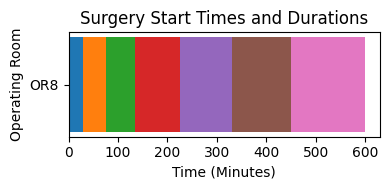

In [1363]:
#Visualization 1

start_times = {}
sorted_surgeries['Start Time'] = None  

# Calculate start times, surgery start after the previous surgery in the same operating room
for idx, row in sorted_surgeries.iterrows():
    room = row['Operating Room']
    duration = row['Duration (Minutes)']
    
    # If it's the first surgery for this room, it starts at 0
    if room not in start_times:
        start_times[room] = 0  # First surgery starts at time 0
    else:
        start_times[room] += sorted_surgeries[(sorted_surgeries['Operating Room'] == room) & (sorted_surgeries.index < idx)].iloc[-1]['Duration (Minutes)']  # Add previous durations
    
    # Assign the computed start time
    sorted_surgeries.at[idx, 'Start Time'] = start_times[room]

# Now, let's plot the start times and durations
fig, ax = plt.subplots(figsize=(4, 2))

# Plot each surgery as a horizontal bar
for idx, row in sorted_surgeries.iterrows():
    ax.barh(row['Operating Room'], row['Duration (Minutes)'], left=row['Start Time'], height=0.5)

# Labeling
ax.set_xlabel('Time (Minutes)')
ax.set_ylabel('Operating Room')
ax.set_title('Surgery Start Times and Durations')

# Show plot
plt.tight_layout()
plt.show()


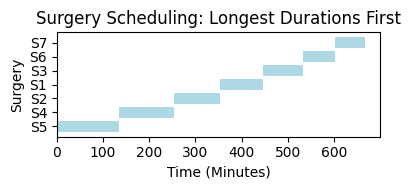

In [1365]:
#Visualization 2

data = {
    'Surgery': ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7'],
    'Duration': level_values 
}

# Create a DataFrame
df = pd.DataFrame(data)

df_sorted = df.sort_values(by='Duration', ascending=False)

df_sorted['Start Time'] = df_sorted['Duration'].cumsum() - df_sorted['Duration']

# Plotting
plt.figure(figsize=(4, 2))

plt.barh(df_sorted['Surgery'], df_sorted['Duration'], left=df_sorted['Start Time'], color='lightblue')

# Adding labels
plt.xlabel('Time (Minutes)')
plt.ylabel('Surgery')
plt.title('Surgery Scheduling: Longest Durations First')

# Show the plot
plt.tight_layout()
plt.show()


### 5. The conclusion of the project (The answer to the question posed by the project).

In [1368]:
obj1 = surgery_model.objective_value
print("Model 1 (Stochastic Model) Value:", obj1)

obj2 = surgery_model1.objective_value
print("Model 2 (Deterministic Model) Value:", obj2)

vss = obj1 - obj2 
print("Value of the Stochastic Solution (VSS):",vss)

Model 1 (Stochastic Model) Value: 1259176.4682306517
Model 2 (Deterministic Model) Value: 668063.2341153261
Value of the Stochastic Solution (VSS): 591113.2341153256


**Conclusion:**

- The implementation of stochastic scheduling has proven to be a valuable tool in optimizing operating room (OR) efficiency and reducing costs.
  
- Our results highlight that the common practice of scheduling longer and more complex cases earlier in the day can negatively impact OR performance metrics, such as utilization and turnover time.
  
- By incorporating variability and uncertainty in the scheduling process, the stochastic model enables a more flexible and cost-effective approach, leading to a significant improvement in performance.
  
- The values of stochastic model (Model 1) and the deterministic model (Model 2) demonstrate a clear advantage.
  
- The Value of the Stochastic Solution (VSS) further emphasizes the cost savings and performance improvements achievable through stochastic scheduling, making it a highly effective strategy for optimizing OR resource management and minimizing operational costs.

### 6. Further reading or extensions of the project that are possible (but not done).

1. **Alternative Heuristic Implementation and Testing**:  
   - Extend the project by implementing **Heuristic 2 (H2)**, which sequences surgeries within each surgeon’s block based on increasing variance of surgery durations, and **Heuristic 3 (H3)**, which uses the coefficient of variation as the sorting criterion.  
   - Test the performance of these heuristics against the current method in terms of schedule feasibility, waiting time, idling time, and operating room (OR) utilization.  
   - Analyze scenarios with multiple ORs and compare the effectiveness of the heuristics in handling larger scheduling complexities.

2. **Sensitivity Analysis on Cost Parameters**:  
   - Conduct a sensitivity analysis to evaluate the impact of cost parameters, such as waiting time costs (`cw`), idling time costs (`cs`), and overtime costs (`c`), on scheduling outcomes.  
   - This analysis could identify critical cost factors and provide insights for fine-tuning the scheduling model for different hospital priorities or budgetary constraints.  

3. **Scalability to Multiple Operating Rooms and Surgeons**:  
   - Explore how the heuristics perform in a multi-OR setting with multiple surgeons, considering interdependencies and shared resources.  
   - Investigate how sequencing decisions in one OR influence the overall schedule and resource utilization.  

4. **Incorporating Real-Time Adjustments**:  
   - Develop a real-time scheduling framework that adjusts to unexpected delays or cancellations, integrating Heuristics 2 and 3 for dynamic sequencing.  

5. **Comparative Analysis with Advanced Scheduling Algorithms**:  
   - Benchmark Heuristics 2 and 3 against optimization-based approaches (e.g., mixed-integer programming) or machine learning-based methods for scheduling.  
   - Study trade-offs between computation time and solution quality.  

These extensions could provide a deeper understanding of the scheduling problem, improve resource utilization, and adapt the model to practical, real-world hospital scenarios.